### Obtained Perplexity: -6.698, Coherence: 0.337, Best Number of Topics= 17

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/Users/flepecki/Downloads/RA_UofT/Topic_based_Gap_Analysis/Anxiety/Data/CSV/rAnxiety16.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#getting rid of deleted values
df['Text']=df['Text'].replace('[deleted]','')
#Combining title and text
df["Post"] = df["Title"] + df["Text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['Title', 'Text'], axis = 1)

In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,Number of Comments,Date Posted,Post
0,53,2016-01-06 20:10:45 EST-0500,You know you have social anxiety when you say ...
1,4,2016-01-01 02:22:08 EST-0500,"15 TED talks on anxiety, fear, and mental well..."
2,89,2016-01-02 02:24:49 EST-0500,Anyone else strangely calm in actual emergenci...
3,16,2016-01-03 07:58:52 EST-0500,"Fuck social anxiety, this is going to be the y..."
4,36,2016-01-02 19:38:52 EST-0500,DAE feel like they are constantly feeling watc...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['you', 'know', 'you', 'have', 'social', 'anxiety', 'when', 'you', 'say', 'hope', 'did', 'ok', 'after', 'youve', 'had', 'conversation', 'with', 'someone']]


In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['you', 'know', 'you', 'have', 'social', 'anxiety', 'when', 'you', 'say', 'hope', 'did', 'ok', 'after', 'youve', 'had', 'conversation', 'with', 'someone']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
#----- CHANGED ------#

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# 6. Filter out least frequently used words
no_below = 0.01
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=17,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['know', 'social', 'anxiety', 'say', 'hope', 've', 'conversation']]
There are 842 unique words in the dictionary, 842 remain after filtering out lest frequent.
842 remain after filtering out most commonly used words based on tfidf scores.


In [15]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"go" + 0.028*"m" + 0.023*"day" + 0.022*"life" + 0.018*"think" + '
  '0.018*"make" + 0.016*"year" + 0.015*"time" + 0.014*"thing" + 0.012*"get"'),
 (1,
  '0.098*"happy" + 0.073*"open" + 0.065*"movie" + 0.065*"door" + 0.059*"love" '
  '+ 0.048*"light" + 0.046*"name" + 0.038*"true" + 0.038*"draw" + '
  '0.035*"allow"'),
 (2,
  '0.034*"work" + 0.033*"week" + 0.027*"help" + 0.027*"take" + 0.024*"doctor" '
  '+ 0.021*"change" + 0.020*"therapy" + 0.017*"therapist" + 0.017*"experience" '
  '+ 0.017*"medication"'),
 (3,
  '0.065*"grow" + 0.061*"away" + 0.059*"family" + 0.058*"man" + '
  '0.055*"outside" + 0.054*"early" + 0.048*"move" + 0.039*"scared" + '
  '0.037*"stay" + 0.036*"parent"'),
 (4,
  '0.058*"feel" + 0.047*"people" + 0.033*"make" + 0.031*"know" + 0.027*"want" '
  '+ 0.026*"even" + 0.026*"always" + 0.025*"m" + 0.023*"think" + 0.022*"talk"'),
 (5,
  '0.177*"exercise" + 0.170*"meditation" + 0.097*"alcohol" + 0.088*"great" + '
  '0.065*"intrusive_thought" + 0.058*"self" + 0

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.698157901268483


In [17]:
#----- CHANGED ------#
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33735637119195017


In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2310,"feel, people, make, know, want, even, always, ...","[know, social, anxiety, say, hope, ve, convers..."
1,1,0.0,0.2273,"go, m, day, life, think, make, year, time, thi...","[te, talk, anxiety, fear, mental, wellness, fi..."
2,2,0.0,0.4063,"go, m, day, life, think, make, year, time, thi...","[anyone_else, strangely, calm, actual, emergen..."
3,3,0.0,0.4680,"go, m, day, life, think, make, year, time, thi...","[fuck, social, anxiety, go, year, take, life, ..."
4,4,4.0,0.2878,"feel, people, make, know, want, even, always, ...","[dae, feel, constantly, feel, judge, example, ..."


In [20]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2310,"feel, people, make, know, want, even, always, ...","[know, social, anxiety, say, hope, ve, convers..."
1,1,0.0,0.2273,"go, m, day, life, think, make, year, time, thi...","[te, talk, anxiety, fear, mental, wellness, fi..."
2,2,0.0,0.4063,"go, m, day, life, think, make, year, time, thi...","[anyone_else, strangely, calm, actual, emergen..."
3,3,0.0,0.4680,"go, m, day, life, think, make, year, time, thi...","[fuck, social, anxiety, go, year, take, life, ..."
4,4,4.0,0.2878,"feel, people, make, know, want, even, always, ...","[dae, feel, constantly, feel, judge, example, ..."
...,...,...,...,...,...
1195,1195,0.0,0.2890,"go, m, day, life, think, make, year, time, thi...","[stare, get, ultrasound, neck, day, wait, room..."
1196,1196,0.0,0.4207,"go, m, day, life, think, make, year, time, thi...","[think, helpfor, long, remember, scared, child..."
1197,1197,0.0,0.4050,"go, m, day, life, think, make, year, time, thi...","[think, go, work, next, stress, point, even, e..."
1198,1198,0.0,0.2490,"go, m, day, life, think, make, year, time, thi...","[job, search, anxiety, feel, kill, little, tas..."


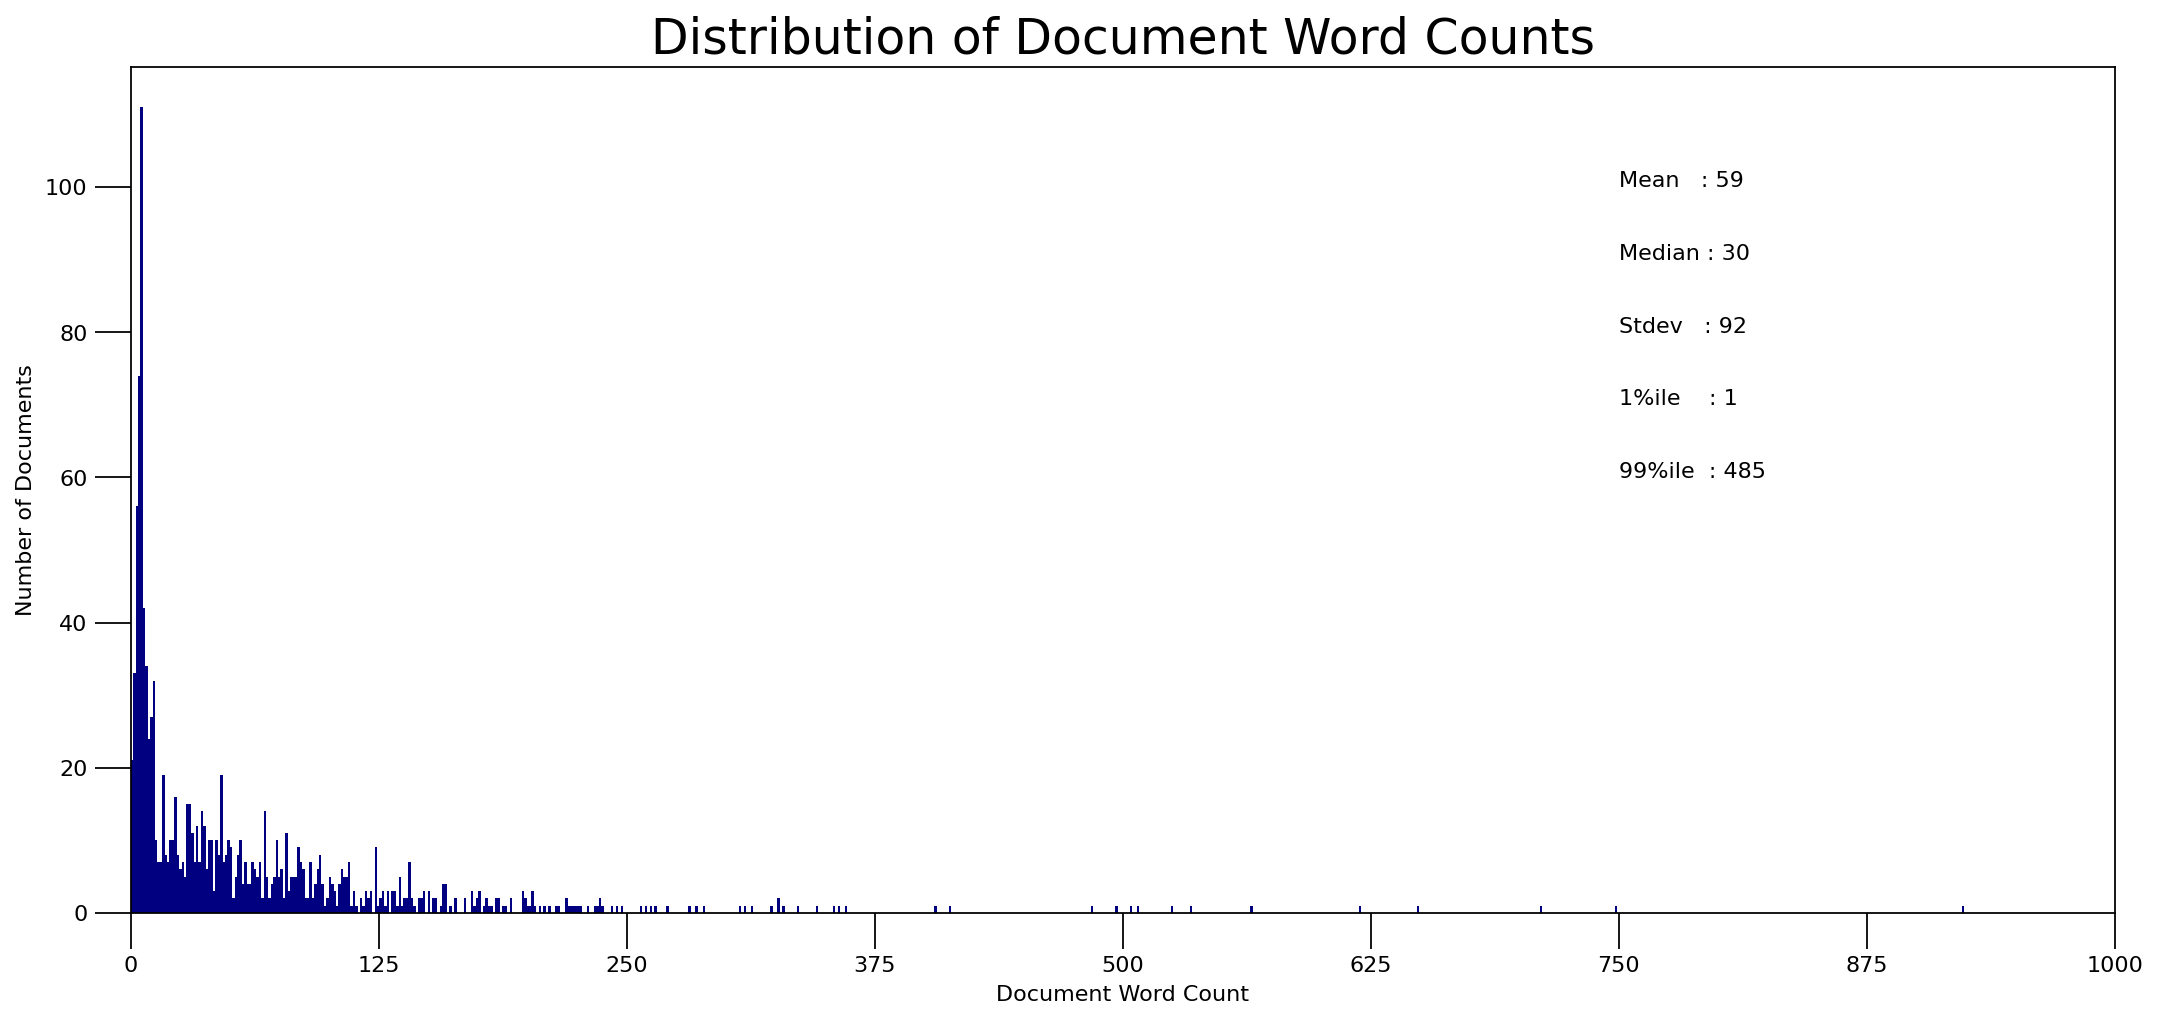

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

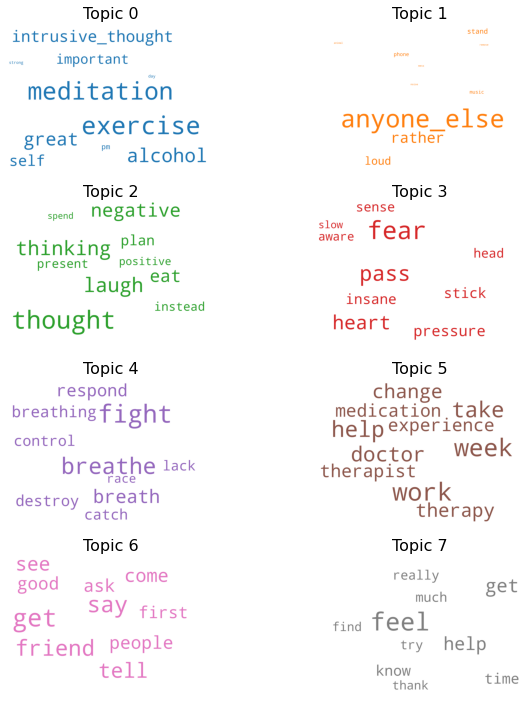

In [22]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
df_dominant_topic.to_csv("Reddit2016.csv")

In [24]:
#----- CHANGED ------#
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
#----- CHANGED ------#
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)

32
[0.3249525752910618, 0.3237921931828943, 0.32496751924975636, 0.3182935444695242, 0.3175717342580861, 0.31722166071748553, 0.3173593836500653, 0.317331271854191, 0.3126622938572037, 0.31626115903526714, 0.30892490608874057, 0.3085384407059753, 0.3059333502299505, 0.303326795093341, 0.304092441430849, 0.3077585334532642, 0.30149443561985184]


(14, 0.32496751924975636)

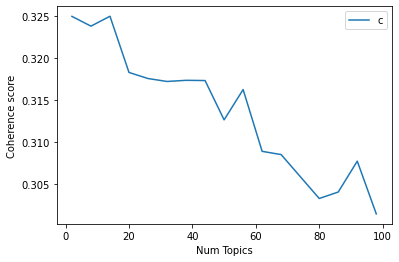

In [26]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x[5])
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, coherance value of the largest difference)
    values: list of coherance numbers
    """
    max_diff = (0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[0]:
            max_diff = (x[i], values[i])
    return max_diff
      
differences(coherence_values, x)

Thus, number of topics=17 is the best possible choice.